# Model build


In [13]:
import numpy as np
import pandas as pd

from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import sklearn.model_selection as msel
import sklearn.inspection as insp
import sklearn.utils as utl
import sklearn.metrics as mtrc
import shap
import xgboost as xgb
 
import matplotlib.pyplot as plt
import seaborn as sns


# Utility Functions

In [2]:
def calculate_metrics(clf, X, y, p=[0.5], phypo=0.5, beta=1):
    p = np.asarray(p)
    
    y_prob = clf.predict_proba(X)[:,-1]
    y_pred = np.greater_equal(np.vstack([y_prob]*p.shape[0]), p.reshape(-1, 1))
    y_stack = np.vstack([y]*p.shape[0])

    tp = (y_stack & y_pred).sum(axis=1)
    tn = ((~y_stack) & (~y_pred)).sum(axis=1)
    fp = ((~y_stack) & y_pred).sum(axis=1)
    fn = (y_stack & (~y_pred)).sum(axis=1)

    with np.errstate(divide='ignore', invalid='ignore'):
        acc = np.divide(tp+tn, tp+tn+fp+fn)
        prec = np.divide(tp, tp+fp)
        rec = np.divide(tp, tp+fn)
        spec = np.divide(tn, tn+fp)
        fbeta = np.divide((1 + beta**2)*prec*rec, (beta**2*prec)+rec)
        fpr = np.divide(fp, fp+tn)
        kap = 1 - np.divide(1-acc, 1-phypo)
    auc = [mtrc.roc_auc_score(y, y_prob)]*p.shape[0]
    
    return pd.DataFrame(
        np.array([p, auc, tp, tn, fp, fn, acc, rec, spec, prec, kap, fbeta]).T,
        columns=["prob", "AUC", "TP", "TN", "FP", "FN", "Acc", "Rec", "Spec", "Prec", "Kap", "F1"],
    )

In [3]:
def plot_metrics(clf, X, y, w=None, threshold=0.5, label="My classifier", fig=None, ax=None):
    y_prob = clf.predict_proba(X)
    y_pred = (y_prob[:,1]>threshold)
    
    cf_matrix = mtrc.confusion_matrix(y, y_pred) #, sample_weight=w)
    acc = mtrc.accuracy_score(y, y_pred, sample_weight=w)
    prec, rec, f1, supp = mtrc.precision_recall_fscore_support(y, y_pred, sample_weight=w)
    kap = mtrc.cohen_kappa_score(y, y_pred, sample_weight=w)
    auc = mtrc.roc_auc_score(y, y_prob[:,1], sample_weight=w)
    fpr, tpr, _ = mtrc.roc_curve(y, y_prob[:,1], sample_weight=w)
    prec_curve, rec_curve, _ = mtrc.precision_recall_curve(y, y_prob[:,1], sample_weight=w)
    
    names = ['TN', 'FP', 'FN', 'TP']
    counts = [f'{value:.0f}' for value in cf_matrix.flatten()]
    perct = [f'{value:.2%}' for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, perct)]
    labels = np.asarray(labels).reshape(2,2)

    if fig is None and ax is None:
        fig, ax = plt.subplots(
            figsize=(12, 12),
            nrows=2, ncols=2,
            gridspec_kw={"hspace": 0.3, "wspace": 0.3},
        )
    elif ax is None:
        ax = fig.subplots(
            nrows=2, ncols=2,
            gridspec_kw={"hspace": 0.3, "wspace": 0.3},
        )

    sns.heatmap(
        cf_matrix,
        annot=labels,
        fmt='',
        cmap='Blues',
        ax=ax[0,0],
        vmin=0.,
        vmax=cf_matrix.sum(),
    )
    ax[0,0].set_xlabel('Predicted label')
    ax[0,0].set_ylabel('True label')

    bars = ax[0,1].bar(
        ["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"],
        [acc, prec[1], rec[1], f1[1], auc],
    )
    for p in bars.patches:
        ax[0,1].annotate(
            f'{p.get_height():.3f}',
            (p.get_x() + p.get_width()/2., p.get_height()),
            ha="center", va="bottom",
        )
    plt.setp(ax[0,1].xaxis.get_majorticklabels(), rotation=30)
    score_min = min([acc, prec[1], rec[1], f1[1], auc])
    score_max = max([acc, prec[1], rec[1], f1[1], auc])
    ax[0,1].set_ylim(
        score_min - 0.05*(score_max-score_min),
        score_max + 0.05*(score_max-score_min),
    )
    ax[0,1].set_ylabel("Score")

    ax[1,0].plot(fpr, tpr, label=label)
    ax[1,0].plot([0,1], [0,1], ls='--', label="Random classifier")
    ax[1,0].legend()
    ax[1,0].set_xlabel('FPR')
    ax[1,0].set_ylabel('TPR')

    ax[1,1].plot(rec_curve, prec_curve, label=f"XGB classifier")
    ax[1,1].set_xlabel('Recall')
    ax[1,1].set_ylabel('Precision')
    
    ret = fig, ax if fig is not None else ax
    return ret

In [4]:
#import data
data = pd.read_parquet('C:\\Users\\ellio\\Desktop\\Python\\scripts\\ML_flight_cancellation_prediction\\datasets\\4-Dataset_for_model.parquet.gzip')

data.dtypes

departure_terminal       object
arrival_terminal         object
weekday                  object
cancelled_outcome         int32
is_codeshare              int32
hour_of_day               int64
flight_tier              object
Per_of_all_H_flights    float64
airline_HR_freq          object
dtype: object

### One hot encoding

In [5]:
#drop arrival terminal and filter departure terminal
data.drop(columns =['arrival_terminal'], inplace = True)

In [6]:
data['departure_terminal'] = data['departure_terminal'].notnull()

False

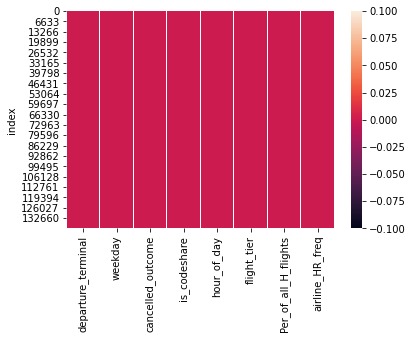

In [7]:
# check missingness
sns.heatmap(data.isnull())

display(data.isnull().any().any())

#cool

In [8]:
# Cols to encode
cols_to_encode = data[['weekday', 'flight_tier', 'airline_HR_freq', 'departure_terminal']]

In [15]:
onehot_encoder = OneHotEncoder(sparse=False) #
encoded = pd.get_dummies(cols_to_encode)
encoded_data = pd.concat([data, encoded], axis = 1)
encoded_data.drop(columns=['weekday', 'flight_tier', 'airline_HR_freq', 'departure_terminal'], inplace = True)
encoded_data.reset_index()
encoded_data

,cancelled_outcome,is_codeshare,hour_of_day,Per_of_all_H_flights,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,flight_tier_afternoon_flight,flight_tier_evening_flight,flight_tier_morning_flight,flight_tier_redeye_flight,airline_HR_freq_freq_airline_21_50,airline_HR_freq_freq_airline_51_100,airline_HR_freq_freq_airline_above100,airline_HR_freq_freq_airline_top20
index,,,,,,,,,,,,,,,,,,,
0,0,1,6,0.000337,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,0,0,6,0.008629,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,0,0,6,0.008629,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,0,1,7,0.011372,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,0,0,7,0.008629,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139287,1,0,22,0.019635,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
139288,0,0,14,0.019635,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
139289,0,0,15,0.019635,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


## Class weights

Determine relative class weighting for `scale_pos_weight`

In [16]:
target = "cancelled_outcome"
class_labels = encoded_data[target].unique()
display(class_labels)

class_weights = utl.class_weight.compute_class_weight(
    'balanced', classes=class_labels, y=encoded_data[target],
)
class_weights_dict = dict(zip(class_labels, class_weights))
scale_pos_weight = class_weights_dict[True]/class_weights_dict[False]
display(class_weights_dict, scale_pos_weight)

array([0, 1])

{0: 0.5173602341440223, 1: 14.900727428326915}

28.80145485665383

## Train-test split
Stratified 70-30 split

In [17]:
y = encoded_data[target].values
X = encoded_data.drop(target, axis=1).values

In [18]:
X_train, X_test, y_train, y_test = msel.train_test_split(X, y, train_size=0.7, stratify=y)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(97504, 18)

(41788, 18)

(97504,)

(41788,)

In [19]:
#Choose hyperparameters - no grid search initially for time.

In [20]:
params = {
    # hyperparameters
    "n_estimators": 150, # AKA: nrounds
    "learning_rate": 0.01, # AKA: eta
    "subsample": 0.7,
    "max_depth": 16,
    "colsample_bytree": 0.9,
    "min_child_weight": 1,
    "min_split_loss": 0, # AKA: gamma
    "scale_pos_weight": scale_pos_weight, # determined above
    
    # fixed parameters
    "booster": "gbtree",
    "objective": "binary:logistic",
    "seed": 300,
}

clf = xgb.XGBClassifier(**params)
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='auc',
    #early_stopping_rounds=20,
    verbose=False,
)

XGBClassifier(colsample_bytree=0.9, learning_rate=0.01, max_depth=16,
              min_split_loss=0, n_estimators=150,
              scale_pos_weight=28.80145485665383, seed=300, subsample=0.7)

In [21]:
df = calculate_metrics(clf, X_test, y_test, p=np.linspace(0., 1., 101))
df.iloc[::5].style.format({
    "prob": "{:.0%}",
    "TP": "{:.0f}", "TN": "{:.0f}", "FP": "{:.0f}", "FN": "{:.0f}",
    "AUC": "{:.1%}", "Acc": "{:.1%}", "Prec": "{:.1%}", "Rec": "{:.1%}", "Spec": "{:.1%}",
    "Kap": "{:.3f}", "F1": "{:.3f}",
}).background_gradient()

,prob,AUC,TP,TN,FP,FN,Acc,Rec,Spec,Prec,Kap,F1
0,0%,71.9%,1402,0,40386,0,3.4%,100.0%,0.0%,3.4%,-0.933,0.065
5,5%,71.9%,1402,0,40386,0,3.4%,100.0%,0.0%,3.4%,-0.933,0.065
10,10%,71.9%,1402,0,40386,0,3.4%,100.0%,0.0%,3.4%,-0.933,0.065
15,15%,71.9%,1360,5820,34566,42,17.2%,97.0%,14.4%,3.8%,-0.656,0.073
20,20%,71.9%,1256,12888,27498,146,33.8%,89.6%,31.9%,4.4%,-0.323,0.083
25,25%,71.9%,1177,16394,23992,225,42.0%,84.0%,40.6%,4.7%,-0.159,0.089
30,30%,71.9%,1107,18571,21815,295,47.1%,79.0%,46.0%,4.8%,-0.058,0.091
35,35%,71.9%,1046,21108,19278,356,53.0%,74.6%,52.3%,5.1%,0.060,0.096
40,40%,71.9%,964,24231,16155,438,60.3%,68.8%,60.0%,5.6%,0.206,0.104
45,45%,71.9%,877,27199,13187,525,67.2%,62.6%,67.3%,6.2%,0.344,0.113


In [22]:
#not a good start. Bad Features

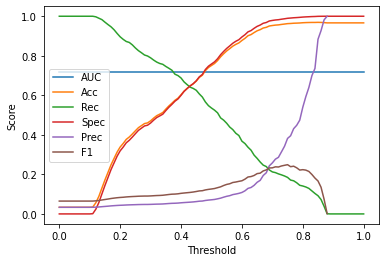

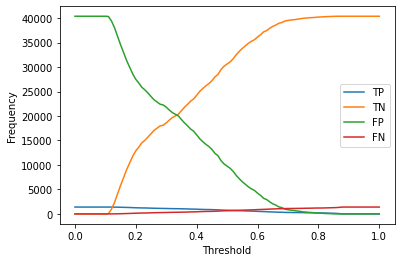

In [23]:
# plots

df.set_index("prob")[["AUC", "Acc", "Rec", "Spec", "Prec", "F1"]].plot(kind="line")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()

df.set_index("prob")[["TP", "TN", "FP", "FN"]].plot(kind="line")
plt.xlabel("Threshold")
plt.ylabel("Frequency")
plt.show()

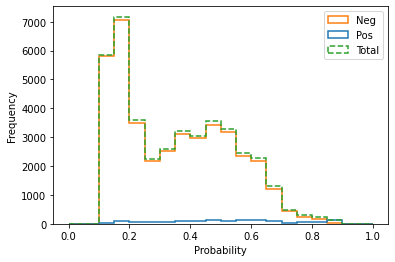

In [24]:
pdf = (df.iloc[::5].set_index("prob")[["TP", "FP"]] - df.iloc[::5].set_index("prob")[["TP", "FP"]].shift(-1))
bins = pdf.index.get_level_values("prob").values
weights = pdf.iloc[:-1].values
plt.hist([bins[:-1]]*weights.shape[-1], bins=bins, weights=weights, histtype='step', label=["Pos", "Neg"], lw=1.5)
plt.hist(bins[:-1], bins=bins, weights=weights.sum(axis=1), histtype='step', label="Total", lw=1.5, ls='--')
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()

(<Figure size 864x864 with 5 Axes>,
 array([[<AxesSubplot:xlabel='Predicted label', ylabel='True label'>,
         <AxesSubplot:ylabel='Score'>],
        [<AxesSubplot:xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:xlabel='Recall', ylabel='Precision'>]], dtype=object))

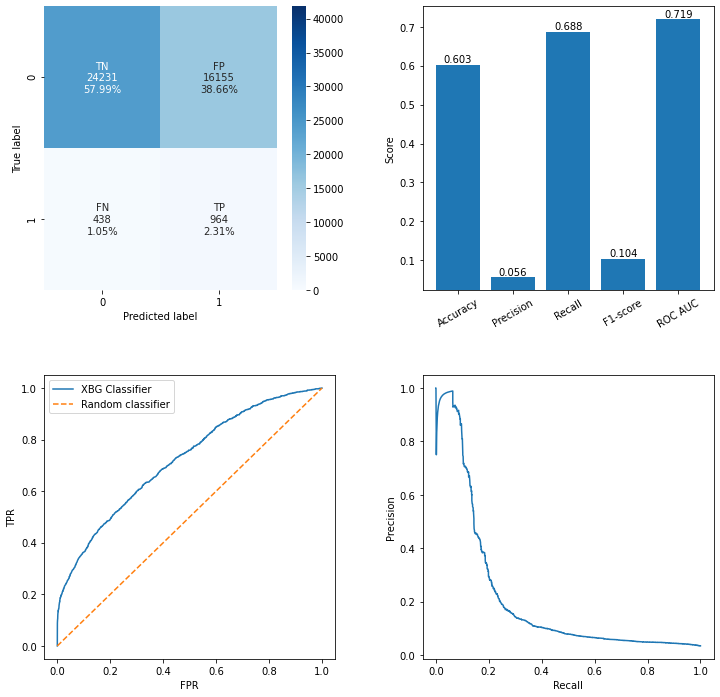

In [30]:
plot_metrics(clf, X_test, y_test, threshold=0.4, label="XBG Classifier")

In [ ]:
# Features

Importance    0.533958
dtype: float32

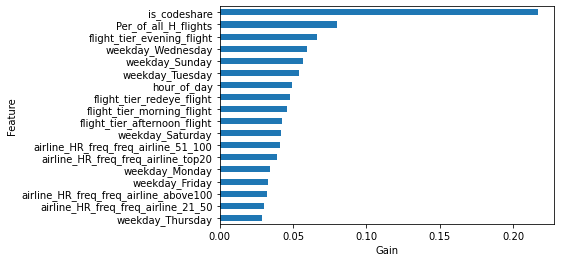

In [102]:
features = pd.DataFrame({
    "Feature": list(encoded_data.drop(target, axis=1).columns),
    "Importance": clf.feature_importances_
}).set_index("Feature").sort_values("Importance", ascending=False)

features.iloc[:20,:][::-1].plot(kind="barh", legend=None)
top6 = features.iloc[:6,:].index.values
plt.xlabel("Gain")

display(features.iloc[:6,:].sum()/features.sum())

In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
x